## Proyecto Final Logística 
---
<li>Luna Moreno</li>
<li>Carles Adam</li>
<li>Enrique Sayas</li>

## 0. Cargar Librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import MDS

from structure import instance, solution
from algorithms import grasp

## 1. Introducción

In [2]:
def resolver(path, alpha, tiempo):
    inst = instance.readInstance(path)
    sol, _, _ = grasp.execute(inst, tiempo, alpha)
    solution.printSolution(sol)
    return sol["sol"]

def visualizar_solucion(path, alpha=None, tiempo=1):
    if alpha != None:
        sol = resolver(path, alpha, tiempo)
    else:
        sol = []

    # Cargar el archivo con las distancias
    distancias = pd.read_table(path, sep = " ", skiprows=1, header=None)
    # Creamos la matriz de distancias
    n_nodos = distancias.loc[:,1].max()+1
    matriz_distancias = np.zeros([n_nodos,n_nodos])

    for _ , fila in distancias.iterrows():
        i, j, distancia = fila
        matriz_distancias[int(i),int(j)] = distancia
        matriz_distancias[int(j),int(i)] = distancia

    # Visualizamos su representación en 2D
    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=33)
    coordenadas_2d = mds.fit_transform(matriz_distancias)

    # Etiquetas para los puntos (opcional)
    colores = ["#efb810" if i in sol else "black" for i, (x, y) in enumerate(coordenadas_2d)]

    plt.figure(figsize=(6, 6))
    plt.scatter(coordenadas_2d[:, 0], coordenadas_2d[:, 1], color=colores, marker='o')     

    plt.title("Puntos en 2D a partir de la matriz de distancias")
    plt.xlabel("Componente 1")
    plt.ylabel("Componente 2")
    plt.grid(True)
    plt.show()

Solution: 0 388 133 136 269 23 153 154 287 416 419 40 41 170 169 302 175 434 51 439 312 57 61 64 452 455 200 72 456 74 332 207 335 209 216 473 347 221 350 224 104 361 235 110 251 114 119 249 379 382 
Objective Value: 7699.17


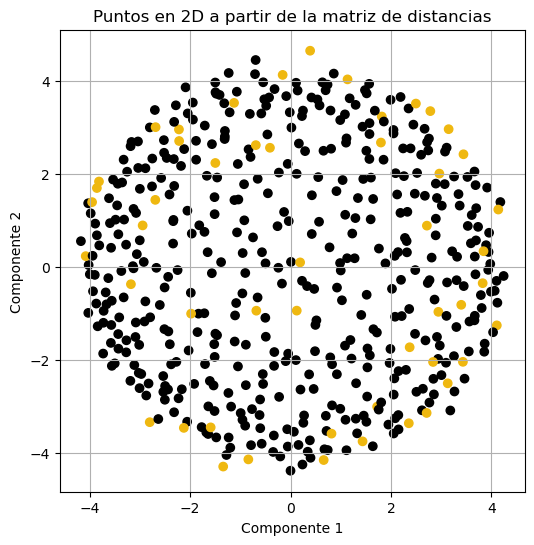

In [3]:
visualizar_solucion("instances/MDG-a_9_n500_m50.txt",alpha=0)

## 2. Modelo GRASP

### 2.1. Calibrar $\alpha$

### 2.1.1 1 segundo de tiempo de ejecución

In [4]:
def calibrar_alfa(path):
    data = pd.read_csv(path, sep=";")
    
    # Calcular el máximo y la desviación estándar
    data["Maximo"] = float(0)
    for archivo in data["archivo"].unique():
        data.loc[data["archivo"] == archivo,"Maximo"] = data[data["archivo"] == archivo]["valor"].values.max()
    data["Dev"] = (data["Maximo"] - data["valor"]) / data["Maximo"]
    
    alpha_max = data.loc[:,["alpha","Dev"]].groupby("alpha").mean("Dev").sort_values("Dev").head(1).index[0]

    data["Color"] = ['Maximo' if x[1]["valor"] == x[1]["Maximo"] else "Otros" for x in data.iterrows()]
    data.loc[data["alpha"] == alpha_max, "Color"] = f"$\\alpha$ = {alpha_max}"

    return data, alpha_max

data_1, alpha_max_1 = calibrar_alfa("resultados/resultados_1.0s.csv")

# Seleccionar el mejor alfa
data_1.loc[:,["alpha","Dev"]].groupby("alpha").mean("Dev").sort_values("Dev").head()

,Dev
alpha,
0.05,0.003572
0.15,0.003696
0.10,0.003820
0.00,0.003961
0.20,0.004626


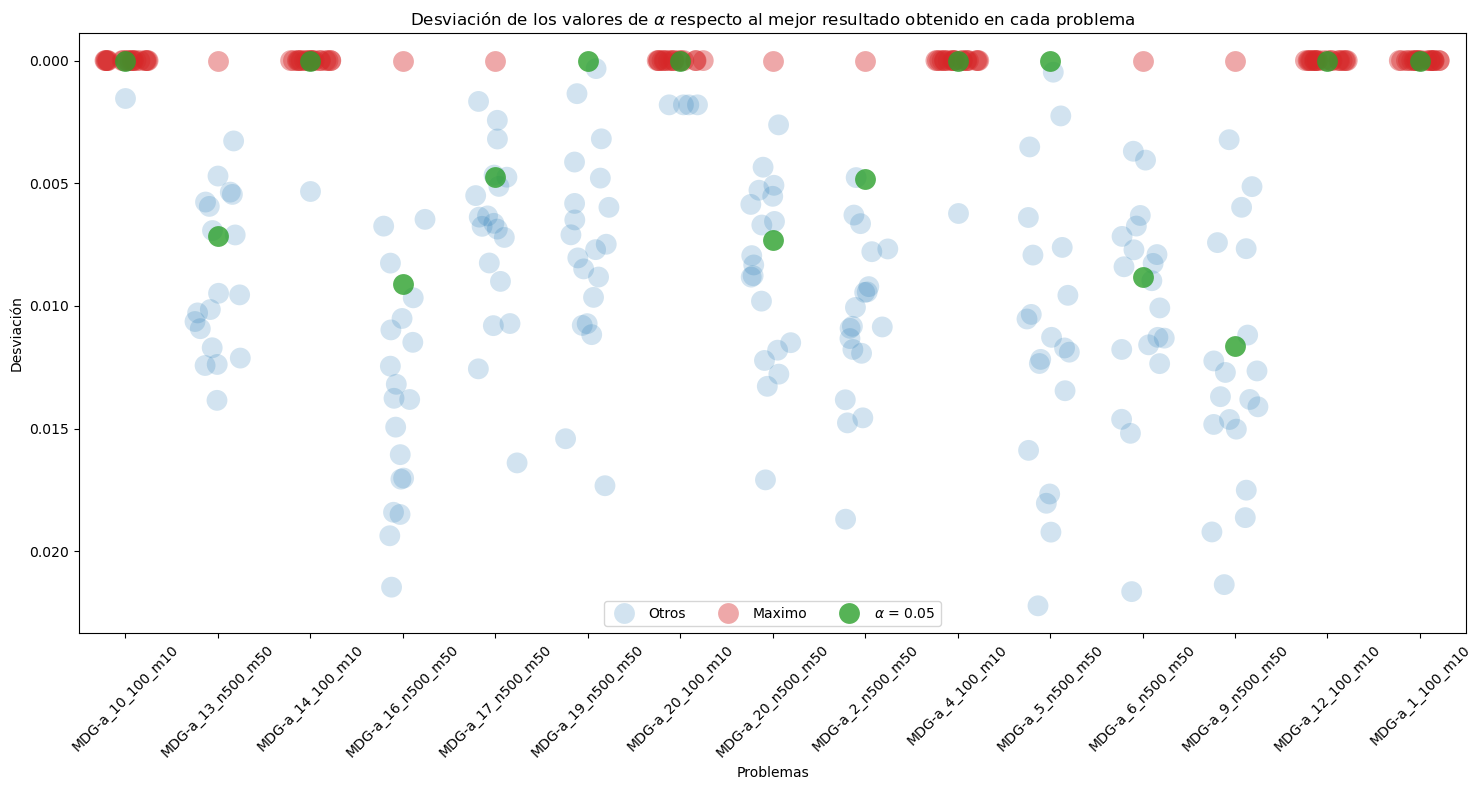

In [5]:
custom_palette = {
    'Otros': '#1f77b4',
    f"$\\alpha$ = {alpha_max_1}": '#2ca02c',
    'Maximo': '#d62728'
}

fig, ax = plt.subplots(figsize=(15,8))
sns.stripplot(data=data_1[data_1["Color"] == "Otros"], x="archivo", y="Dev", hue="Color", alpha=0.2, ax=ax, size=15, jitter=0.25, palette=custom_palette)
sns.stripplot(data=data_1[data_1["Color"] == "Maximo"], x="archivo", y="Dev", hue="Color", alpha=0.4, ax=ax, size=15, jitter=0.25, palette=custom_palette)
sns.stripplot(data=data_1[data_1["Color"] == f"$\\alpha$ = {alpha_max_1}"], x="archivo", y="Dev", hue="Color", alpha=0.8, ax=ax, size=15, jitter=0.25, palette=custom_palette)
ax.tick_params(axis='x', rotation=45)
ax.set_xlabel("Problemas")
ax.set_ylabel("Desviación")
ax.invert_yaxis()
plt.title("Desviación de los valores de $\\alpha$ respecto al mejor resultado obtenido en cada problema")
plt.legend(ncol=3, loc="lower center", bbox_to_anchor=(0.5, 0))
plt.tight_layout()
plt.show()

### 2.1.2 5 segundos de tiempo de ejecución

In [6]:
data_5, alpha_max_5 = calibrar_alfa("resultados/resultados_5.0s.csv")

# Seleccionar el mejor alfa
data_5.loc[:,["alpha","Dev"]].groupby("alpha").mean("Dev").sort_values("Dev").head()

,Dev
alpha,
0.10,0.001653
0.05,0.002375
0.00,0.002507
0.15,0.002597
0.40,0.002935


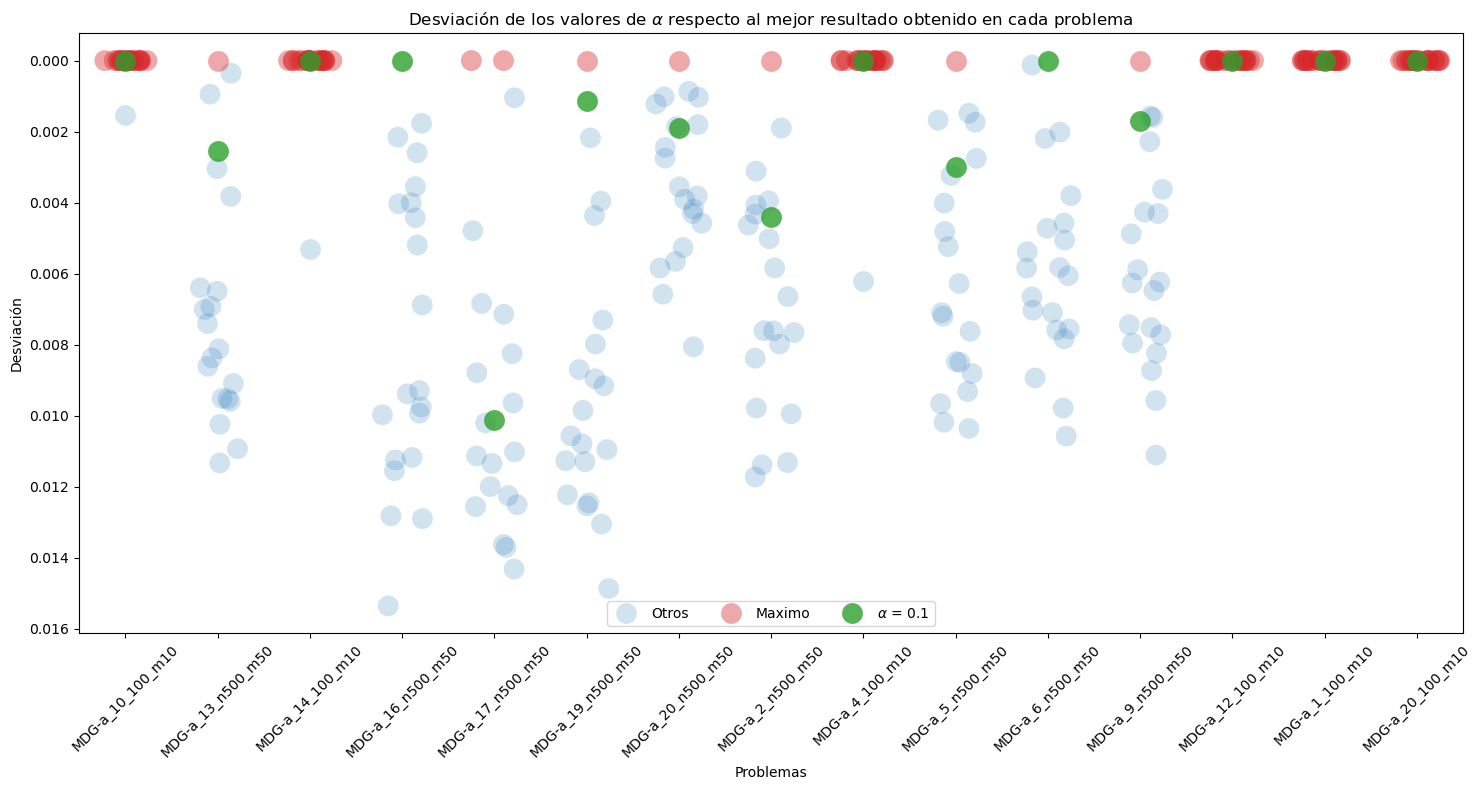

In [7]:
custom_palette = {
    'Otros': '#1f77b4',
    f"$\\alpha$ = {alpha_max_5}": '#2ca02c',
    'Maximo': '#d62728'
}

fig, ax = plt.subplots(figsize=(15,8))
sns.stripplot(data=data_5[data_5["Color"] == "Otros"], x="archivo", y="Dev", hue="Color", alpha=0.2, ax=ax, size=15, jitter=0.25, palette=custom_palette)
sns.stripplot(data=data_5[data_5["Color"] == "Maximo"], x="archivo", y="Dev", hue="Color", alpha=0.4, ax=ax, size=15, jitter=0.25, palette=custom_palette)
sns.stripplot(data=data_5[data_5["Color"] == f"$\\alpha$ = {alpha_max_5}"], x="archivo", y="Dev", hue="Color", alpha=0.8, ax=ax, size=15, jitter=0.25, palette=custom_palette)
ax.tick_params(axis='x', rotation=45)
ax.set_xlabel("Problemas")
ax.set_ylabel("Desviación")
ax.invert_yaxis()
plt.title("Desviación de los valores de $\\alpha$ respecto al mejor resultado obtenido en cada problema")
plt.legend(ncol=3, loc="lower center", bbox_to_anchor=(0.5, 0))
plt.tight_layout()
plt.show()

### 2.1.3 10 segundos de tiempo de ejecución

In [8]:
data_10, alpha_max_10 = calibrar_alfa("resultados/resultados_10.0s.csv")

# Seleccionar el mejor alfa
data_10.loc[:,["alpha","Dev"]].groupby("alpha").mean("Dev").sort_values("Dev").head()

,Dev
alpha,
0.05,0.002668
0.50,0.002839
0.10,0.002919
0.15,0.002924
0.00,0.002976


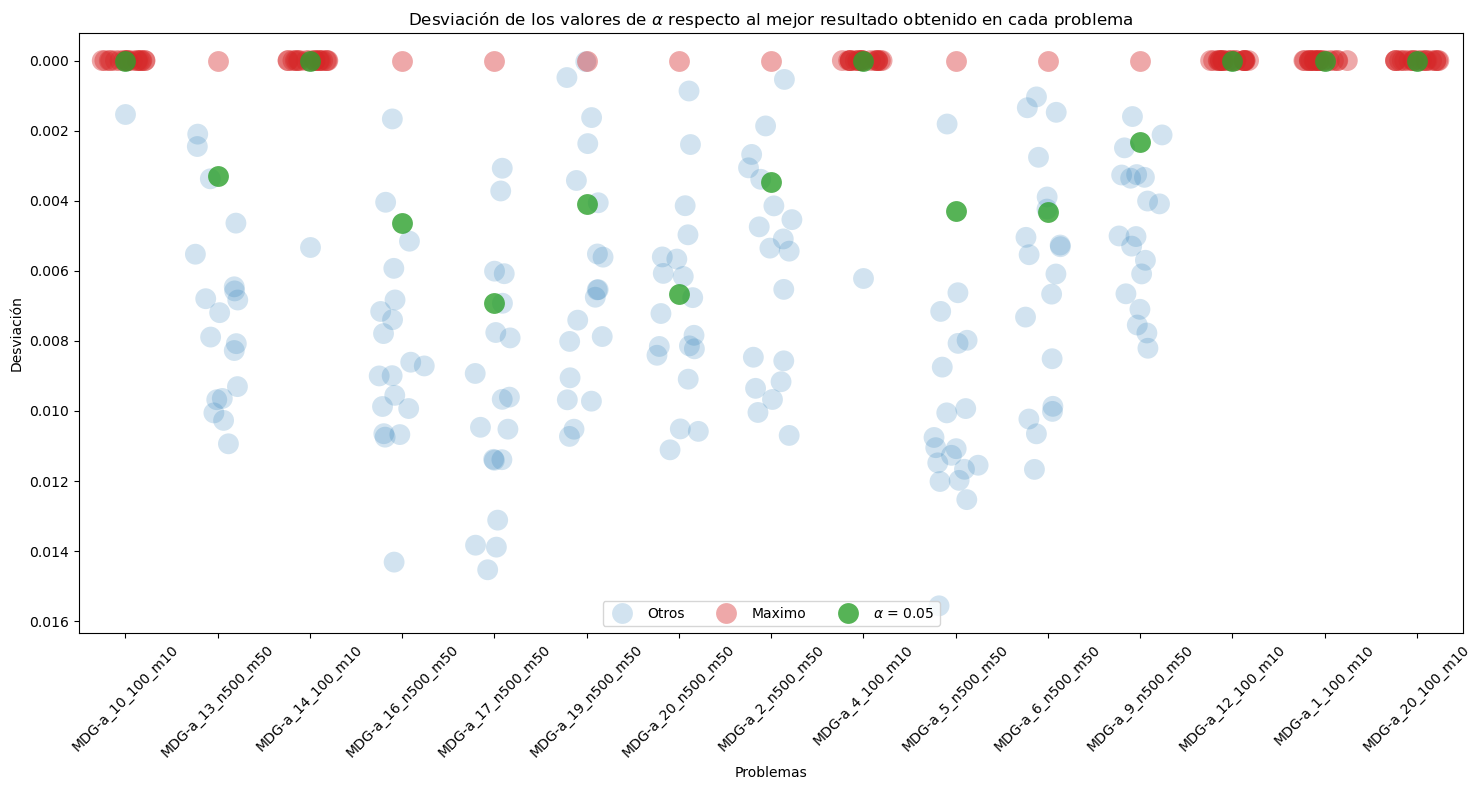

In [9]:
custom_palette = {
    'Otros': '#1f77b4',
    f"$\\alpha$ = {alpha_max_10}": '#2ca02c',
    'Maximo': '#d62728'
}

fig, ax = plt.subplots(figsize=(15,8))
sns.stripplot(data=data_10[data_10["Color"] == "Otros"], x="archivo", y="Dev", hue="Color", alpha=0.2, ax=ax, size=15, jitter=0.25, palette=custom_palette)
sns.stripplot(data=data_10[data_10["Color"] == "Maximo"], x="archivo", y="Dev", hue="Color", alpha=0.4, ax=ax, size=15, jitter=0.25, palette=custom_palette)
sns.stripplot(data=data_10[data_10["Color"] == f"$\\alpha$ = {alpha_max_10}"], x="archivo", y="Dev", hue="Color", alpha=0.8, ax=ax, size=15, jitter=0.25, palette=custom_palette)
ax.tick_params(axis='x', rotation=45)
ax.set_xlabel("Problemas")
ax.set_ylabel("Desviación")
ax.invert_yaxis()
plt.title("Desviación de los valores de $\\alpha$ respecto al mejor resultado obtenido en cada problema")
plt.legend(ncol=3, loc="lower center", bbox_to_anchor=(0.5, 0))
plt.tight_layout()
plt.show()

### 2.1.4 Selección de $\alpha$

In [10]:
data_todos = pd.concat([data_1, data_5, data_10])
data_todos["segundos"] = np.floor(data_todos["tiempo"])
data_todos = data_todos[["alpha","segundos","Dev"]]
data_todos_grouped = data_todos.groupby(["alpha","segundos"]).mean().reset_index()

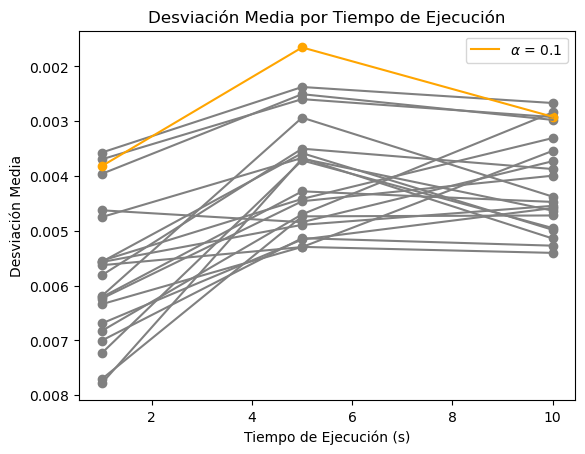

In [11]:
fig, ax = plt.subplots()
for alpha in [i / 100 for i in range(0,101)]:
    if alpha != 0.1:
        ax.plot(data_todos_grouped[data_todos_grouped["alpha"] == alpha]["segundos"], data_todos_grouped[data_todos_grouped["alpha"] == alpha]["Dev"], color = "gray")
        ax.scatter(x = data_todos_grouped[data_todos_grouped["alpha"] == alpha]["segundos"], y = data_todos_grouped[data_todos_grouped["alpha"] == alpha]["Dev"], color = "gray")
ax.plot(data_todos_grouped[data_todos_grouped["alpha"] == 0.1]["segundos"], data_todos_grouped[data_todos_grouped["alpha"] == 0.1]["Dev"], color = "orange", label = "$\\alpha$ = 0.1")
ax.scatter(x = data_todos_grouped[data_todos_grouped["alpha"] == 0.1]["segundos"], y = data_todos_grouped[data_todos_grouped["alpha"] == 0.1]["Dev"], color = "orange")
ax.invert_yaxis()
ax.set_xlabel("Tiempo de Ejecución (s)")
ax.set_ylabel("Desviación Media")
ax.set_title("Desviación Media por Tiempo de Ejecución")
plt.legend()
plt.show()

Se utilizará $\alpha = 0.1$.

## 3. Path Relinking

## 4. Comparación

In [12]:
data_1_0_1 = data_1[data_1["alpha"] == 0.1].loc[:,["archivo","alpha","valor","tiempo"]]
data_5_0_1 = data_5[data_5["alpha"] == 0.1].loc[:,["archivo","alpha","valor","tiempo"]]
data_10_0_1 = data_10[data_10["alpha"] == 0.1].loc[:,["archivo","alpha","valor","tiempo"]]
data_60_0_1 = pd.read_csv("resultados/resultados_60.0s.csv", sep=";")

In [13]:
data_0_1 = pd.concat([data_1_0_1, data_5_0_1, data_10_0_1, data_60_0_1]).reset_index(drop=True)
data_0_1["Modelo"] = "GRASP"
data_0_1.head()

,archivo,alpha,valor,tiempo,Modelo
0,MDG-a_10_100_m10,0.1,355.50,1.0003,GRASP
1,MDG-a_12_100_m10,0.1,354.25,1.0004,GRASP
2,MDG-a_13_n500_m50,0.1,7713.20,1.0383,GRASP
3,MDG-a_14_100_m10,0.1,356.06,1.0003,GRASP
4,MDG-a_16_n500_m50,0.1,7669.38,1.0003,GRASP


In [14]:
data_pr_1 = pd.read_csv("resultados/resultados_pr_1.0s.csv", sep=";")
data_pr_5 = pd.read_csv("resultados/resultados_pr_5.0s.csv", sep=";")
data_pr_10 = pd.read_csv("resultados/resultados_pr_10.0s.csv", sep=";")
data_pr_60 = pd.read_csv("resultados/resultados_pr_60.0s.csv", sep=";")

data_pr = pd.concat([data_pr_1, data_pr_5, data_pr_10, data_pr_60]).reset_index(drop=True)
data_pr["Modelo"] = "GRASP + PR"
data_pr.head()

,archivo,alpha,valor,tiempo,Modelo
0,MDG-a_10_100_m10,0.1,355.50,1.036431,GRASP + PR
1,MDG-a_12_100_m10,0.1,354.25,1.037456,GRASP + PR
2,MDG-a_13_n500_m50,0.1,7613.60,1.442570,GRASP + PR
3,MDG-a_14_100_m10,0.1,354.17,1.042210,GRASP + PR
4,MDG-a_16_n500_m50,0.1,7628.30,1.330580,GRASP + PR


In [15]:
data_0_1 = pd.concat([data_0_1, data_pr]).reset_index(drop=True)
data_0_1.head()

,archivo,alpha,valor,tiempo,Modelo
0,MDG-a_10_100_m10,0.1,355.50,1.0003,GRASP
1,MDG-a_12_100_m10,0.1,354.25,1.0004,GRASP
2,MDG-a_13_n500_m50,0.1,7713.20,1.0383,GRASP
3,MDG-a_14_100_m10,0.1,356.06,1.0003,GRASP
4,MDG-a_16_n500_m50,0.1,7669.38,1.0003,GRASP


In [16]:
data_0_1_60 = data_0_1[data_0_1["tiempo"] > 15]
data_0_1_60 = data_0_1_60.reset_index(drop=True)

In [17]:
maximos = data_0_1_60.groupby("archivo").max().reset_index().loc[:,["archivo","valor"]]
maximos = maximos.rename(columns={"valor":"max"})
maximos

,archivo,max
0,MDG-a_10_100_m10,355.50
1,MDG-a_12_100_m10,354.25
2,MDG-a_13_n500_m50,7759.96
3,MDG-a_14_100_m10,356.06
4,MDG-a_16_n500_m50,7759.13
5,MDG-a_17_n500_m50,7776.53
6,MDG-a_19_n500_m50,7741.96
7,MDG-a_1_100_m10,360.15
8,MDG-a_20_100_m10,349.31
9,MDG-a_20_n500_m50,7685.81


In [18]:
data_0_1_60= data_0_1_60.set_index('archivo').join(maximos.set_index('archivo')).reset_index()
data_0_1_60["dif"] = (data_0_1_60["max"] - data_0_1_60["valor"]) / data_0_1_60["max"]
data_0_1_60

,archivo,alpha,valor,tiempo,Modelo,max,dif
0,MDG-a_10_100_m10,0.1,355.50,60.001400,GRASP,355.50,3.197942e-16
1,MDG-a_12_100_m10,0.1,354.25,60.000200,GRASP,354.25,3.209226e-16
2,MDG-a_13_n500_m50,0.1,7747.88,60.019100,GRASP,7759.96,1.556709e-03
3,MDG-a_14_100_m10,0.1,356.06,60.000600,GRASP,356.06,3.192912e-16
4,MDG-a_16_n500_m50,0.1,7759.13,60.098600,GRASP,7759.13,0.000000e+00
5,MDG-a_17_n500_m50,0.1,7769.82,60.032100,GRASP,7776.53,8.628527e-04
6,MDG-a_19_n500_m50,0.1,7722.34,60.039700,GRASP,7741.96,2.534242e-03
7,MDG-a_1_100_m10,0.1,360.15,60.000100,GRASP,360.15,4.734979e-16
8,MDG-a_20_100_m10,0.1,349.31,60.000500,GRASP,349.31,4.881917e-16
9,MDG-a_20_n500_m50,0.1,7685.81,60.026200,GRASP,7685.81,0.000000e+00


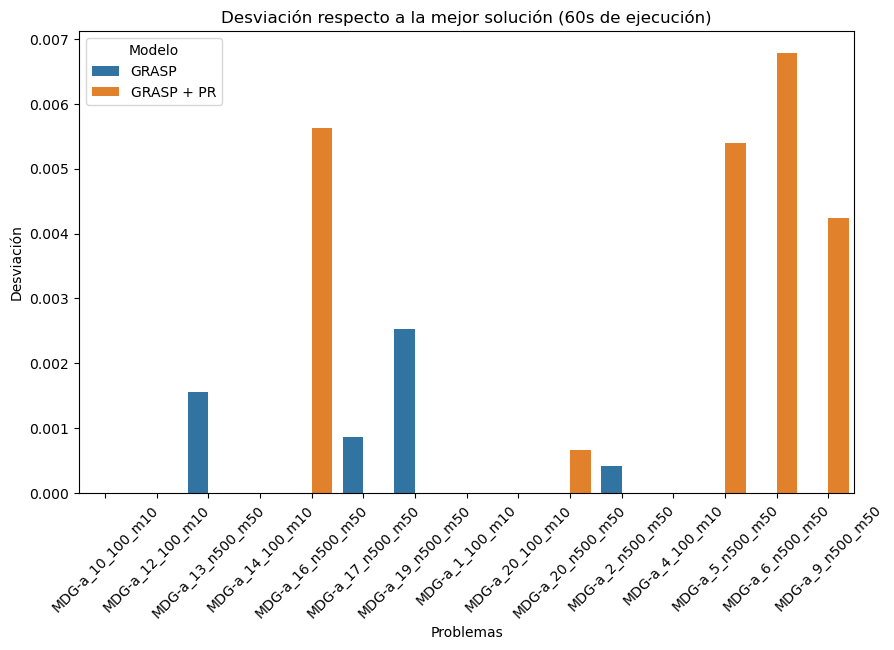

In [19]:
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(data=data_0_1_60, x='archivo', y='dif', hue='Modelo', ax=ax, errorbar=None)
ax.tick_params(axis='x', rotation=45)
ax.set_title("Desviación respecto a la mejor solución (60s de ejecución)")
ax.set_xlabel("Problemas")
ax.set_ylabel("Desviación")
plt.show()

## 5. Conclusiones

## 6. Bibliografía

Resende, M. G. C., Ribeiro, C. C., Glover, F., & Martí, R. (2010). Scatter search and path-relinking: Fundamentals, advances, and applications. En M. Gendreau & J.-Y. Potvin (Eds.), Handbook of Metaheuristics (pp. 87–107). Springer. https://doi.org/10.1007/978-1-4419-1665-5_4